In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
tf.__version__

'1.15.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import dataset
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Hessian/X_train.txt', delim_whitespace = True).values
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Hessian/X_test.txt', delim_whitespace = True).values
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Hessian/y_train.txt', delim_whitespace = True).values
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Hessian/y_test.txt', delim_whitespace = True).values

In [0]:
y_train2 = y_train.copy()

In [6]:
X_train[:10,:]

array([[3.70000000e+01, 2.50000000e+01, 2.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 9.90166667e+02],
       [3.90000000e+01, 2.40000000e+01, 3.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 1.45008333e+03],
       [3.80000000e+01, 2.20000000e+01, 4.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 1.89912500e+03],
       [3.70000000e+01, 2.00000000e+01, 5.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 2.34762500e+03],
       [3.60000000e+01, 1.90000000e+01, 6.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 2.80729167e+03],
       [3.50000000e+01, 2.00000000e+01, 7.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 3.28679167e+03],
       [3.50000000e+01, 2.00000000e+01, 8.00000000e+00, 5.00000000e+00,
        0.00000000e+00,            nan,            nan, 3.

In [7]:
y_train[:10]

array([[11534],
       [11038],
       [10777],
       [10764],
       [11032],
       [11508],
       [11806],
       [12457],
       [13214],
       [13783]])

In [0]:
# Preprocesamiento de datos faltantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
imputer = imputer.fit(X_train[:,5:7])
X_train[:,5:7] = imputer.transform(X_train[:,5:7])

In [0]:
# Escalar características 
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler(feature_range = (0, 1))
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [0]:
# Escalar la salida
from sklearn.preprocessing import MinMaxScaler
sc_y = MinMaxScaler(feature_range = (0, 1))
y_train = sc_y.fit_transform(y_train)

In [0]:
X_train = X_train.T
y_train = y_train.T
X_test = X_test.T

batch_size = X_train.shape[1]
m = X_train.shape[1]
n_features = X_train.shape[0]
n_hidden = 5
n_output = y_train.shape[0]
mini_batch_size = 256

In [0]:
x = tf.placeholder(tf.float32, shape=[n_features, None])
y = tf.placeholder(tf.float32, shape=[n_output, None])

# Inicializar parámetros
#w1_flat = tf.Variable(tf.truncated_normal([n_features * n_hidden,]), dtype = tf.float32)
w1_flat = tf.Variable(tf.random_uniform([n_features * n_hidden,], maxval = 0.01), dtype = tf.float32)
b1_flat = tf.Variable(tf.zeros([n_hidden, ]), dtype = tf.float32)
#w2_flat = tf.Variable(tf.truncated_normal([n_hidden * n_output,]), dtype = tf.float32)
w2_flat = tf.Variable(tf.random_uniform([n_hidden * n_output,], maxval = 0.01), dtype = tf.float32)
b2_flat = tf.Variable(tf.zeros([n_output, ]), dtype = tf.float32)

In [0]:
# Reshape
W1 = tf.reshape(w1_flat, [n_hidden, n_features])
b1 = tf.reshape(b1_flat, [n_hidden, 1])
W2 = tf.reshape(w2_flat, [n_output, n_hidden])
b2 = tf.reshape(b2_flat, [n_output, 1])

# Making a prediction and comparing it to the true output
Z1 = tf.matmul(W1, x) + b1
A1 = tf.sigmoid(Z1)
Z2 = tf.matmul(W2, A1) + b2
pred = Z2
loss = tf.reduce_mean(0.5 * (y - pred)**2)

In [0]:
# Aux functions
def random_mini_batches(X, Y, mini_batch_size = 64):
        
    m = X.shape[1]                  # number of training examples
    mini_batches = []
       
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def sigmoid(Z):    
    A = 1/(1+np.exp(-Z))
    #cache = Z
    return A

def return_parameters(parameters, n_hidden, n_features, n_output):
    W1 = np.reshape(parameters[0], [n_hidden, n_features])
    b1 = np.reshape(parameters[1], [n_hidden, 1])
    W2 = np.reshape(parameters[2], [n_output, n_hidden])
    b2 = np.reshape(parameters[3], [n_output, 1])
    
    parameters = {'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    
    return parameters


def forward_test(X_test,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1,X_test) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = Z2

    return A2

In [0]:
# Preprocessings to the weight update
wrt_variables = [w1_flat, b1_flat, w2_flat, b2_flat]
grads = tf.gradients(loss, wrt_variables)
hess = tf.hessians(loss, wrt_variables)
inv_hess = [tf.matrix_inverse(h) for h in hess]

update_directions = [
    - (0.0004) * tf.reduce_sum(h) * g
    for h, g in zip(inv_hess, grads)
]
op_apply_updates = [
    v.assign_add(up)
    for v, up in zip(wrt_variables, update_directions)
]

Costo despues de la época 0: 0.009539
Costo despues de la época 1: 0.007254
Costo despues de la época 2: 0.006036
Costo despues de la época 3: 0.005136
Costo despues de la época 4: 0.004509
Costo despues de la época 5: 0.004031
Costo despues de la época 6: 0.003656
Costo despues de la época 7: 0.003358
Costo despues de la época 8: 0.003123
Costo despues de la época 9: 0.002939
Costo despues de la época 10: 0.002795
Costo despues de la época 11: 0.002679
Costo despues de la época 12: 0.002588
Costo despues de la época 13: 0.002572
Costo despues de la época 14: 0.002560
Costo despues de la época 15: 0.002525
Costo despues de la época 16: 0.002479
Costo despues de la época 17: 0.002424
Costo despues de la época 18: 0.002376
Costo despues de la época 19: 0.002333
Costo despues de la época 20: 0.002295
Costo despues de la época 21: 0.002262
Costo despues de la época 22: 0.002232
Costo despues de la época 23: 0.002204
Costo despues de la época 24: 0.002179
Costo despues de la época 25: 0.002

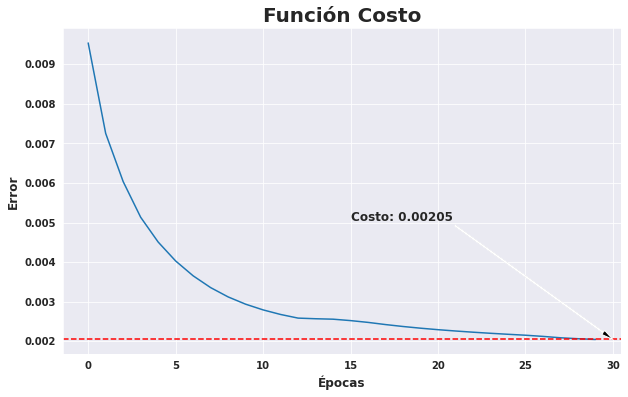

In [44]:
import tensorflow as tf

####
# 2. Proceed to solve the regression
####
costs = []
# Initialize variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
        sess.run(init)
        for epoch in range(30):
            epoch_cost = 0
            num_minibatches = int(m/mini_batch_size)
            minibatches =  random_mini_batches(X_train,y_train,mini_batch_size)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                minibatch_cost, _ = sess.run([loss, op_apply_updates],feed_dict={x: X_train,y: y_train})
                epoch_cost += minibatch_cost/num_minibatches
            print('Costo despues de la época %i: %f'%(epoch ,epoch_cost))
            costs.append(epoch_cost)
        min_loss = min(np.squeeze(costs))
        plt.figure(figsize=(10,6))
        plt.plot(np.squeeze(costs))
        plt.axhline(y=min_loss,color='r',linestyle='--')
        plt.title("Función Costo",fontsize=20,fontweight='bold')
        plt.xlabel("Épocas",fontsize=12,fontweight='bold')
        plt.ylabel("Error",fontsize=12,fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        xyz = (len(costs),costs[-1])
        xyzz = (len(costs)/2,costs[-1] + 0.003)
        plt.annotate("Costo: %0.5f" % costs[-1], xy=xyz, xytext=xyzz,
                     arrowprops=dict(facecolor='black',shrink=1,width=1,headwidth=5),
                     fontsize=12,fontweight='bold')
        plt.show()
        prediction = sess.run(pred, feed_dict={x:X_train})
        parameters = sess.run(wrt_variables, feed_dict={x: X_train})


parameters_opt = return_parameters(parameters, n_hidden, n_features, n_output)

In [45]:
# Evaluación de la red neuronal - datos de prueba
y_pred_test = forward_test(X_test,parameters_opt)
y_pred_test = sc_y.inverse_transform(y_pred_test)
y_pred_test = y_pred_test.T


R2_test = r2_score(y_test, y_pred_test)
MAE = mean_absolute_error(y_test, y_pred_test)
print('MAE : %f'%MAE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(y_test,y_pred_test)
print('MAPE : %f'%MAPE)

MAE : 815.567009
MAPE : 5.776682


In [0]:
# Evaluación de la red neuronal en los datos de entrenamiento
y_pred_train = forward_test(X_train,parameters_opt)
y_pred_train = sc_y.inverse_transform(y_pred_train).T
R2_train = r2_score(y_train2, y_pred_train)

In [47]:
y_pred_test.shape

(8773, 1)

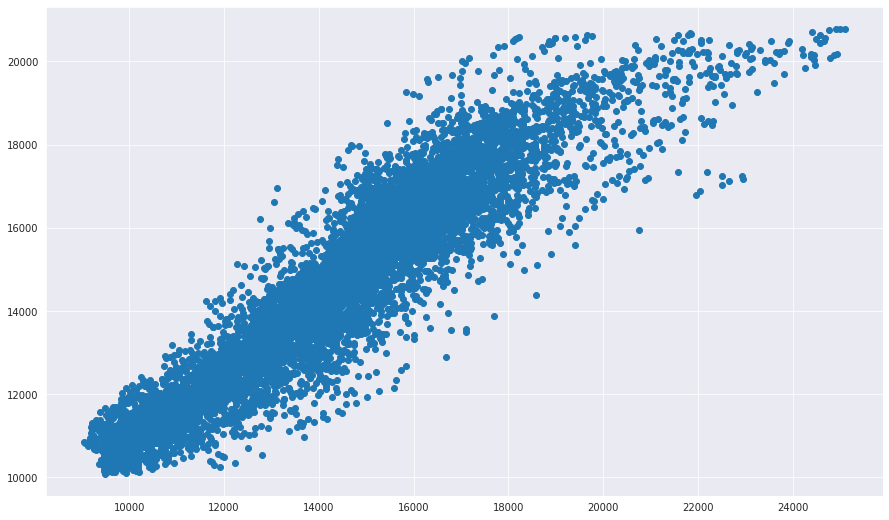

In [48]:
# Resultados
plt.figure(figsize = (15,9))
plt.scatter(y_test, y_pred_test)
plt.show()